[( 8, 26,    298, 1) (17,  9,   1374, 1) (12, 29,   2009, 0) ...
 (13, 27, 299506, 1) (17, 17, 299761, 0) ( 9, 12, 303492, 0)]
(4033,)


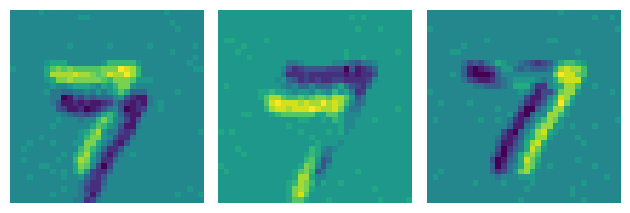

In [20]:
# pip install tonic
# pip install snntorch


#  Using Tonic to Load Neuromorphic Datasets

import tonic
import random

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
rand_ind = random.randint(0, len(dataset) - 1)
events, target = dataset[rand_ind]



# Each row corresponds to a single event, which consists of four parameters: (x-coordinate, y-coordinate, timestamp, polarity).
print(events)
print(events.shape)

tonic.utils.plot_event_grid(events)



In [28]:
print(events)
print(events.shape)


[( 8, 26,    298, 1) (17,  9,   1374, 1) (12, 29,   2009, 0) ...
 (13, 27, 299506, 1) (17, 17, 299761, 0) ( 9, 12, 303492, 0)]
(4033,)


In [15]:
# However, neural nets don’t take lists of events as input. 
# The raw data must be converted into a suitable representation, such as a tensor. 
# We can choose a set of transforms to apply to our data before feeding it to our network. 
# The neuromorphic camera sensor has a temporal resolution of microseconds, which when converted into a dense representation, 
# ends up as a very large tensor. 
# That is why we bin events into a smaller number of frames using the ToFrame transformation, 
# which reduces temporal precision but also allows us to work with it in a dense format.


import tonic.transforms as transforms
import tonic

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)



from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

# even faster (more RAM required)
# from tonic import MemoryCachedDataset

# cached_trainset = MemoryCachedDataset(trainset)


batch_size = 32
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

def load_sample_batched():
    events, target = next(iter(cached_dataloader))
    
%timeit -o -r 10 load_sample_batched()


5.25 ms ± 221 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 5.25 ms ± 221 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [17]:
import random

chosen_dataset = cached_dataloader.dataset

rand_ind = random.randint(0, len(chosen_dataset) - 1)
events, target = chosen_dataset[rand_ind]
tonic.utils.plot_event_grid(events)



TypeError: argument of type 'NoneType' is not iterable

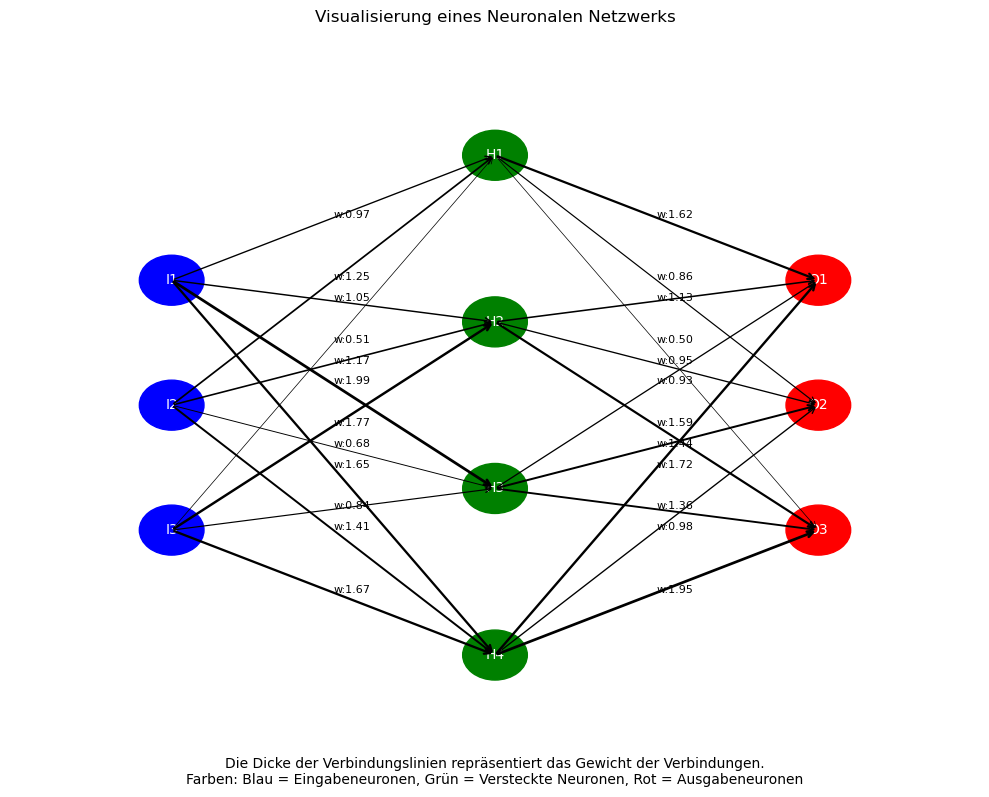

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Funktionen für die Visualisierung
def draw_neuron(ax, pos, neuron_label, neuron_color):
    """ Zeichnet ein einzelnes Neuron an der angegebenen Position """
    circle = plt.Circle(pos, radius=0.1, color=neuron_color, fill=True)
    ax.add_artist(circle)
    ax.text(*pos, neuron_label, ha='center', va='center', color='white')

def connect_neurons(ax, pos_a, pos_b, weight):
    """ Verbindet zwei Neuronen mit einer Linie, die das Gewicht repräsentiert """
    ax.annotate('', xy=pos_b, xytext=pos_a, arrowprops=dict(arrowstyle='->', color='black', lw=weight))
    # Calculate midpoint for annotation
    mid_x, mid_y = (pos_a[0] + pos_b[0]) / 2, (pos_a[1] + pos_b[1]) / 2
    ax.text(mid_x, mid_y, f'w:{weight:.2f}', color='black', fontsize=8)

# Erzeugung der Abbildung
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 2.5)
ax.axis('off')

# Positionen der Neuronen
input_positions = [(0, i) for i in np.linspace(1.5, 0.5, 3)]
output_positions = [(2, i) for i in np.linspace(1.5, 0.5, 3)]
hidden_positions = [(1, i) for i in np.linspace(2, 0, 4)]

# Zeichnen der Neuronen
for i, pos in enumerate(input_positions):
    draw_neuron(ax, pos, f'I{i+1}', 'blue')
for i, pos in enumerate(hidden_positions):
    draw_neuron(ax, pos, f'H{i+1}', 'green')
for i, pos in enumerate(output_positions):
    draw_neuron(ax, pos, f'O{i+1}', 'red')

# Verbinden der Neuronen
for ip in input_positions:
    for hp in hidden_positions:
        weight = np.random.uniform(0.5, 2.0)
        connect_neurons(ax, ip, hp, weight)

for hp in hidden_positions:
    for op in output_positions:
        weight = np.random.uniform(0.5, 2.0)
        connect_neurons(ax, hp, op, weight)

# Titel und Erklärung
ax.set_title('Visualisierung eines Neuronalen Netzwerks')
plt.figtext(0.5, 0.01, 'Die Dicke der Verbindungslinien repräsentiert das Gewicht der Verbindungen.\n'
                        'Farben: Blau = Eingabeneuronen, Grün = Versteckte Neuronen, Rot = Ausgabeneuronen',
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()

plt.show()


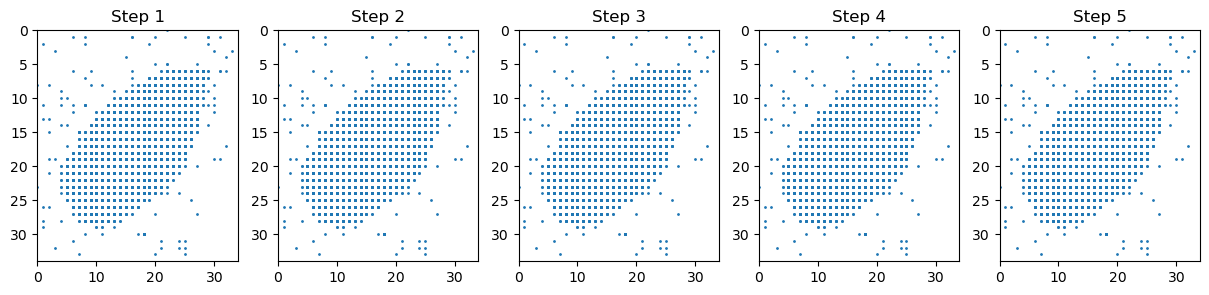

In [19]:
import tonic
import matplotlib.pyplot as plt
import numpy as np
import random

# Load the dataset
dataset = tonic.datasets.NMNIST(save_to='./data', train=True)

def plot_event_grid(events, ax):
    """Plot events on given axes."""
    x, y, _, _ = zip(*events)
    ax.scatter(x, y, s=1)
    ax.set_xlim(0, 34)
    ax.set_ylim(0, 34)
    ax.invert_yaxis()  # Invert y-axis to match image orientation

def create_collage(dataset, indices):
    """Create a collage of events from given indices."""
    all_events = []
    for i, ind in enumerate(indices):
        events, _ = dataset[ind]
        # Offset events to create a collage
        offset_x = (i % 5) * 35  # Adjust these values as needed
        offset_y = (i // 5) * 35
        offset_events = [(x+offset_x, y+offset_y, t, p) for x, y, t, p in events]
        all_events.extend(offset_events)
    return all_events

def plot_progression(dataset, steps):
    """Plot the progression of event collages."""
    fig, axes = plt.subplots(1, len(steps), figsize=(15, 3))
    for i, step in enumerate(steps):
        events = create_collage(dataset, step)
        plot_event_grid(events, axes[i])
        axes[i].set_title(f"Step {i+1}")
    plt.show()

# Randomly select indices for demonstration
random_indices = [random.randint(0, len(dataset) - 1) for _ in range(5)]

# Define steps for the progression
steps = [random_indices[:i+1] for i in range(len(random_indices))]

# Plot the progression
plot_progression(dataset, steps)


In [21]:
# training a network on the N-MNIST classification task

# Now let’s actually train a network on the N-MNIST classification task. 
# We start by defining our caching wrappers and dataloaders. 
# While doing that, we’re also going to apply some augmentations to the training data. 
# The samples we receive from the cached dataset are frames, 
# so we can make use of PyTorch Vision to apply whatever random transform we would like.


import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 32
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

# A mini-batch now has the dimensions (time steps, batch size, channels, height, width). 
# The number of time steps will be set to that of the longest recording in the mini-batch, 
# and all other samples will be padded with zeros to match it.

event_tensor, target = next(iter(trainloader))

print(event_tensor.shape)

torch.Size([307, 32, 2, 34, 34])


In [24]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Data Augmentation Visualization
def show_augmented_images(dataset, transform, num_images=4):
    fig, axs = plt.subplots(2, num_images, figsize=(12, 6))

    for i in range(num_images):
        # Original image
        original, _ = dataset[i]
        axs[0, i].imshow(original.squeeze(), cmap='gray')
        axs[0, i].set_title("Original")
        axs[0, i].axis('off')

        # Augmented image
        augmented = transform(original)
        axs[1, i].imshow(augmented.squeeze(), cmap='gray')
        axs[1, i].set_title("Augmented")
        axs[1, i].axis('off')

    plt.show()

def show_batch(trainloader):
    event_tensor, _ = next(iter(trainloader))
    # Assuming the first channel is to be visualized
    # Adjust the index 1 to visualize a different channel if needed
    images_to_display = event_tensor[:, 0, ...].unsqueeze(1)
    grid = make_grid(images_to_display, nrow=8)  # Adjust nrow based on your preference
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Batch Visualization")
    plt.axis('off')
    plt.show()

# Function to create a collage from multiple batches
def create_collage(trainloader, num_batches=5):
    all_images = []
    for _, (event_tensor, _) in zip(range(num_batches), trainloader):
        # Collecting the first channel of each event tensor
        all_images.append(event_tensor[:, 0, ...].unsqueeze(1))

    # Concatenate images from different batches
    all_images = torch.cat(all_images, dim=0)
    grid = make_grid(all_images, nrow=8)  # Adjust nrow based on the desired layout
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Collage of Multiple Batches")
    plt.axis('off')
    plt.show()

# Apply the visualization functions
#show_augmented_images(trainset, transform)
# Call the functions
show_batch(trainloader)
create_collage(trainloader)


RuntimeError: The size of tensor a (2) must match the size of tensor b (34) at non-singleton dimension 2

In [6]:
# dualchannel SNN
#from snntorch import spikegen
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate


# SNN & CNN HYbrid
# GOAL: Tempo Estimation from Mel Spectrograms

class SpikingNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SpikingNet, self).__init__()

        #self.surr_grad = surrogate.FastSigmoid.apply
        self.surr_grad = surrogate.ATan.apply
        self.LEARN = True
        self.batch_normalization =  False

        
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.sigmoid = nn.Sigmoid()
        self.lif1 = snn.Leaky(beta=0.2, learn_threshold=self.LEARN, learn_beta=self.LEARN, learn_graded_spikes_factor=self.LEARN)
        
        self.pool = nn.MaxPool2d(2)


        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.lif2 = snn.Leaky(beta=0.2, learn_threshold=self.LEARN, learn_beta=self.LEARN, learn_graded_spikes_factor=self.LEARN)



        self.fc1_size = 64 * 1 * 16  # Number of channels * new height * new width
        # self.fc1_size = 64 * (input_shape[1] // 3 // 2) * (input_shape[2] // 2) #old
        self.fc1 = nn.Linear(self.fc1_size, 1000)
        self.lif3 = snn.Leaky(beta=0.2, learn_threshold=self.LEARN, learn_beta=self.LEARN, learn_graded_spikes_factor=self.LEARN)

        # Das Gehirn kategorisiert und identifiziert Tempi basierend auf den erhaltenen Informationen. 
        # Diese Schicht stellt die finale Kategorisierung oder Identifikation von Tempi dar
        self.fc2 = nn.Linear(1000, num_classes)



    def forward(self, x, mem=None, debug=False):
        from snntorch import utils
        utils.reset(self)  # Resets hidden states for all LIF neurons in the network

        # Debug information dictionary
        debug_info = {}

        # Initialize memory if it's the first step
        if mem is None:
            mem = {
                #'conv1': torch.zeros(x.size(0), 32, x.size(2)//3, x.size(3), device=x.device),
                # 'conv1': torch.zeros(x.size(0), 32, x.size(2), x.size(3), device=x.device),
                # 'conv2': torch.zeros(x.size(0), 64, x.size(2)//2//3, x.size(3)//2, device=x.device),
                # 'fc1': torch.zeros(x.size(0), 1000, device=x.device)
                
                'conv1': torch.zeros(x.size(0), 32, x.size(2), x.size(3), device=x.device),
                'conv2': torch.zeros(x.size(0), 64, x.size(2)//2, x.size(3)//2, device=x.device),
                'fc1': torch.zeros(x.size(0), 1000, device=x.device)
            }

        if debug:
            print("Input shape:", x.shape)


        # Convolutional layers and LIF neurons with optional inhibition
        out_conv1_raw = self.conv1(x)
        if self.batch_normalization:
            out_conv1 = self.bn1(out_conv1_raw) # output after batch normalization
            out_conv1 = self.sigmoid(out_conv1) # contrain values to [0,1]
            x1, mem['conv1'] = self.lif1(out_conv1, mem['conv1'])
        else:
            x1, mem['conv1'] = self.lif1(out_conv1_raw, mem['conv1'])

        x1_surr = self.surr_grad(x1)
        x1_pool = self.pool(x1_surr)

        out_conv2_raw = self.conv2(x1_pool)
        
        if self.batch_normalization:
            out_conv2 = self.bn2(out_conv2_raw) # output after batch normalization
            out_conv2 = self.sigmoid(out_conv2) # contrain values to [0,1]
            x2, mem['conv2'] = self.lif2(out_conv2, mem['conv2'])
        else: 
            x2, mem['conv2'] = self.lif2(out_conv2_raw, mem['conv2'])

        x2 = self.surr_grad(x2)
        x2_pool = self.pool(x2)

        # Flatten for the fully connected layer with dynamic size adjustment
        batch_size = x2_pool.size(0)
        num_features = x2_pool.size(1) * x2_pool.size(2) * x2_pool.size(3)
        x2_pool_flatten = x2_pool.view(batch_size, -1)

        # If this is the first pass or if the input size has changed, adjust the fully connected layer
        if not hasattr(self, 'fc1') or self.fc1.in_features != num_features:
            self.fc1 = nn.Linear(num_features, 1000).to(x2_pool.device)
            self.fc1.weight.data.normal_(0, 0.01)  # Re-initialize weights
            self.fc1_size = num_features  # Update fc1 size

        # Pass flattened x2_pool to the first fully connected layer
        x_fc_raw, mem['fc1'] = self.lif3(self.fc1(x2_pool_flatten), mem['fc1'])
        x_fc = self.surr_grad(x_fc_raw)

        # Output layer
        x_out = self.fc2(x_fc)

        # Collect debug information if in debug mode
        if debug:
            debug_info = {
                'conv1_mem': mem['conv1'],
                'conv1_raw': out_conv1_raw,
                'x1_surr': x1_surr,
                'conv1_spike': x1,
                'conv2_mem': mem['conv2'],
                'conv2_raw': out_conv2_raw,
                'conv2_spike': x2,
                'fc1_mem': mem['fc1'],
                'fc1_spike': x_fc_raw,
            }
            return x_out, mem, debug_info

        return x_out, mem

# Define your SNN model

num_classes = 10
input_shape = None
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingNet(input_shape, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
#optimizer = torch.optim.Adam(model.parameters(), lr=2e-2, betas=(0.9, 0.999))

# Der Scheduler moduliert die Lernrate, analog zur Art und Weise, 
# wie der auditorische Kortex seine Anpassungsfähigkeit über die Zeit moduliert, 
# um optimal auf eine Vielzahl von auditiven Reizen zu reagieren. 
# In der Biologie passen sich neuronale Systeme durch Mechanismen wie 
# Hebb'sches Lernen oder Langzeitpotenzierung an. Der Scheduler in diesem Modell 
# ermöglicht ähnliche adaptive Lernmechanismen.
epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

In [9]:
# import matplotlib
# matplotlib.use('TkAgg')
# import matplotlib.pyplot as plt

import time


num_batches = len(trainloader)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

start_time_all = time.time()

num_epochs = 20
time_steps = 4
THRESHOLD_ACCURACY = 75.0  # adjust this value as needed
initial_batch_size = int(batch_size)  # assuming batch_size_new is defined somewhere in your code
increased_batch_size = initial_batch_size * 2
has_increased_batch_size = False
model.batch_normalization = True
model.LEARN = True

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()
    
    for i, (inputs, labels ) in enumerate(trainloader):
        batch_start_time = time.time()
                
        inputs, labels = inputs.to(device), labels.to(device)
          
        optimizer.zero_grad()

        mem = None
        # for step in range(inputs.shape[0]):
        #     #print(f"input", inputs[step].shape)
        #     outputs, mem = model(inputs[step], mem)
        #     #print(f"step {step}/{inputs.shape[0]}", end='\r')
        
        for step in range(3):
            #print(f"input", inputs[step].shape)
            outputs, mem = model(inputs[0], mem)
            #print(f"step {step}/{inputs.shape[0]}", end='\r')
        
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).sum().item()

        batch_duration = time.time() - batch_start_time
        estimated_remaining_time = batch_duration * (num_batches - (i + 1))
        
        batch_accuracy = 100 * correct / total  # Calculate batch accuracy
            
        if epoch == 2:
            model.batch_normalization = False
        
        # if i >= 20:
        #     break
        
        estimated_min = estimated_remaining_time/60
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{num_batches}, Acc: {batch_accuracy:.3f}% , Loss: {loss.item():.4f}, Est. Remaining Time: {estimated_remaining_time:.2f} secs or {estimated_min:.1f} mins", end='\r')

    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * num_epochs
    remaining_time = (num_epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(trainloader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total
    training_accuracies.append(accuracy)
    print(f"\nEpoch {epoch + 1}/{num_epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    
    

end_time = time.time() - start_time_all
print(f"{num_epochs} epochs took {end_time/60.0:.2f} mins")


KeyboardInterrupt: 

In [10]:
# Defining our network

# We will use snnTorch + PyTorch to construct a CSNN, just as in the previous tutorial. 
# The convolutional network architecture to be used is: 12C5-MP2-32C5-MP2-800FC10

# 12C5 is a 5x5 convolutional kernel with 12 filters

# MP2 is a 2x2 max-pooling function

# 800FC10 is a fully-connected layer that maps 800 neurons to 10 outputs

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
class SpikingNN(nn.Module):
    def __init__(self, beta=0.5):
        super(SpikingNN, self).__init__()
        
        # neuron and simulation parameters
        spike_grad = surrogate.atan()

        # Define network layers
        self.layers = nn.Sequential(
            nn.Conv2d(2, 12, 5),
            nn.MaxPool2d(2),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_beta=True, learn_graded_spikes_factor=True, learn_threshold=True),
            nn.Conv2d(12, 32, 5),
            nn.MaxPool2d(2),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_beta=True, learn_graded_spikes_factor=True, learn_threshold=True),
            nn.Flatten(),
            nn.Linear(32*5*5, 10),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, learn_beta=True, learn_graded_spikes_factor=True, learn_threshold=True)
        )

    def forward_pass(self, x):
        spk_rec = []
        utils.reset(self.layers)  # resets hidden states for all LIF neurons in net
        #print(x.size(0))
        for step in range(x.size(0)):  # x.size(0) = number of time steps
            spk_out, _ = self.layers(x[step])
            spk_rec.append(spk_out)
            
        return torch.stack(spk_rec)
      


# Cross Entropy Loss can be applied to the total spike count to maximize the number of spikes from the correct class.
# Another option from the snn.functional module is to specify the target number of spikes from correct and incorrect classes. 
# The approach below uses the Mean Square Error Spike Count Loss, 
# which aims to elicit spikes from the correct class 80% of the time, and 20% of the time from incorrect classes.
# Encouraging incorrect neurons to fire could be motivated to avoid dead neurons.


net = SpikingNN().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

num_epochs = 2
loss_hist = []
acc_hist = []

In [12]:
# training loop
from IPython.display import clear_output

num_iters = 5
batch_len = len(trainloader)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        #clear_output(wait=True)  # This will clear the output of the cell where the function is called

        data = data.to(device)
        targets = targets.to(device)

        net.train()
        # print(f"Data shape: {data.shape}")
        spk_rec = net.forward_pass(data)
        loss_val = loss_fn(spk_rec, targets)
        # print(f"spk_rec shape: {spk_rec.shape}")
        # print(f"targets shape: {targets.shape}")

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())


        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Epoch {epoch}, Iteration {i}/{batch_len}, Train Loss: {loss_val.item():.2f}, Accuracy: {acc * 100:.2f}%", end="\r")

        # training loop breaks after num_iters iterations
        # if i == num_iters:
        #   break
      


KeyboardInterrupt: 

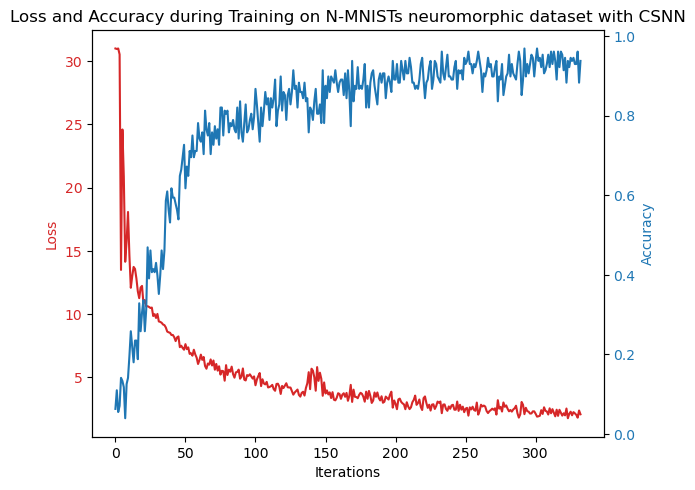

In [17]:
# plot loss and acc

import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Make the first plot: Loss values
color = 'tab:red'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  

# Make the second plot: Accuracy values
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_hist, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To make sure that the right y-label is not slightly clipped
plt.title('Loss and Accuracy during Training on N-MNISTs neuromorphic dataset with CSNN')
plt.show()

Overall Accuracy: 94.67%
Overall Loss: 2.0309


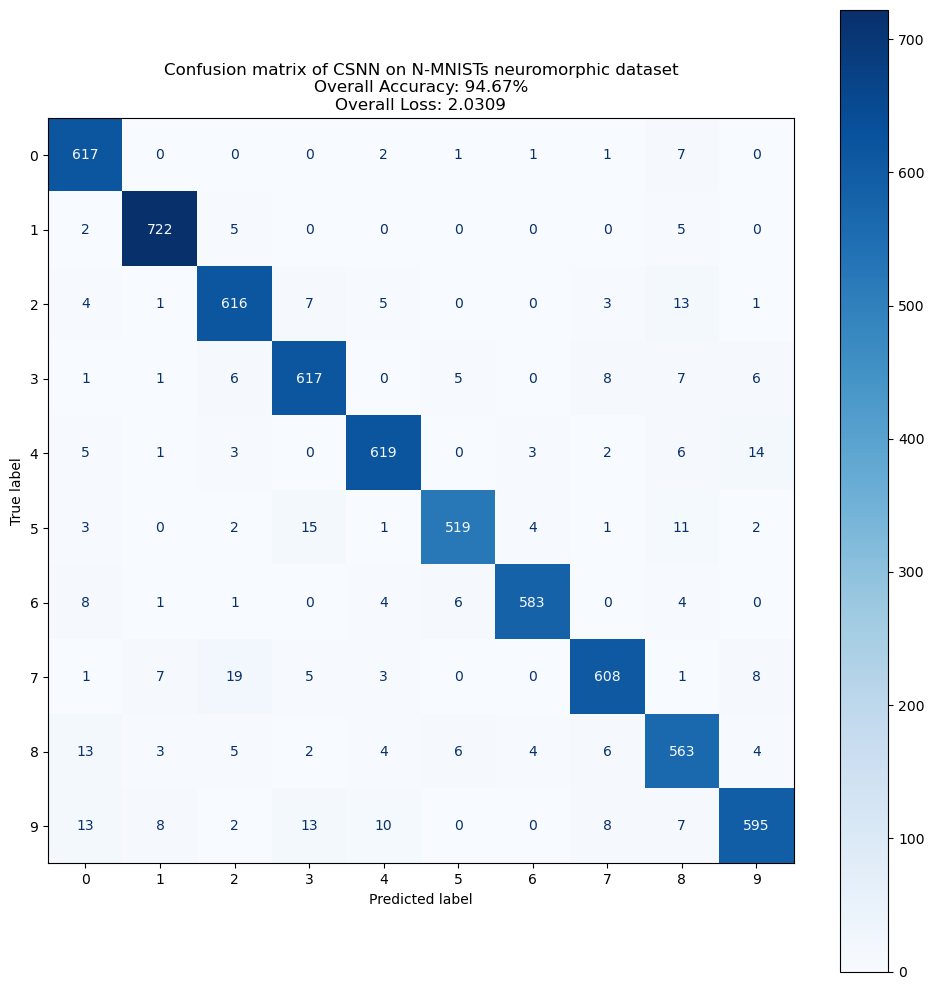

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

# Variables to store cumulative loss and correct predictions
cumulative_loss = 0.0
correct_predictions = 0
total_samples = 0

# Set the network to evaluation mode
net.eval()

# Set number of batches to evaluate on
num_batches_to_evaluate = 50  # You can adjust this number based on your needs

# Loop through the test data
for batch_idx, (data, targets) in enumerate(testloader):
    if batch_idx >= num_batches_to_evaluate:
        break
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        spk_rec = net.forward_pass(data)
        loss_val = loss_fn(spk_rec, targets)
        cumulative_loss += loss_val.item() * data.size(0)  # Multiply by batch size to get total loss for this batch
    
    
    # Sum spikes over time and obtain class predictions
    summed_spikes = spk_rec.sum(dim=0)  # Summing over the time dimension
    
    # Get predicted classes
    predictions = torch.argmax(summed_spikes, dim=1)

    # Calculate the accuracy using SF.accuracy_rate and update the number of correct predictions
    acc = SF.accuracy_rate(spk_rec, targets)
    correct_predictions += acc * data.size(0)  # This assumes accuracy_rate returns a value between 0 and 1

    true_labels.extend(targets.cpu().numpy())
    predicted_labels.extend(predictions.cpu().numpy())
    total_samples += data.size(0)
    print(f"Batch {batch_idx+1}/{num_batches_to_evaluate}", end='\r')

# Calculate overall accuracy and loss
overall_accuracy = 100 * correct_predictions / total_samples
average_loss = cumulative_loss / total_samples

overall_accuracy = f"Overall Accuracy: {overall_accuracy:.2f}%"
overall_loss = f"Overall Loss: {average_loss:.4f}"
print(overall_accuracy)
print(overall_loss)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0])).plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
ax.set_title(f'Confusion matrix of CSNN on N-MNISTs neuromorphic dataset\n{overall_accuracy}\n{overall_loss}')
plt.tight_layout()
plt.show()



The target label is: 9


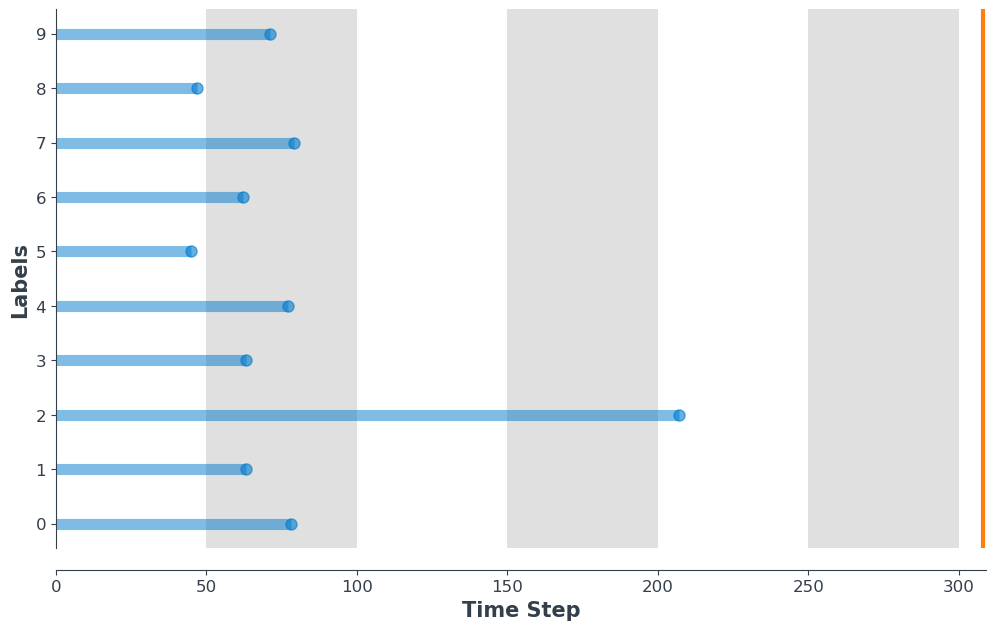

In [38]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

#plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())

In [78]:
# Save the model parameters (weights)
torch.save(net.state_dict(), 'neuro_csnn2.pth')

In [81]:
# First, initialize the model architecture
net = SpikingNN()
net.load_state_dict(torch.load('neuro_csnn2.pth'))
# If using CUDA
net.to(device)

net.eval()




SpikingNN(
  (layers): Sequential(
    (0): Conv2d(2, 12, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Leaky()
    (3): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Leaky()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=800, out_features=10, bias=True)
    (8): Leaky()
  )
)

: 